In [255]:
import pandas as pd
from pathlib import Path

# Import Data
We need to concatenate all readings from all csvs into a single DataFrame.

In [256]:
csv_files = list(Path('/content/measurements/').glob('*.csv'))
dfs = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Successfully loaded and concatenated 54 CSV files into a single DataFrame.
The final DataFrame has 1883625 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-10-20T00:00:37Z,lm393,is_raining,0.000000,NaN
1,2025-10-20T00:00:37Z,veml7700,lux_lx,0.000000,lx
2,2025-10-20T00:00:37Z,bme280,temperature_c,25.119434,degC
3,2025-10-20T00:00:37Z,bme280,pressure_pa,101185.070312,Pa
4,2025-10-20T00:00:37Z,bme280,humidity_pct,100.000000,pct


**Reasoning**:
The subtask of loading and concatenating the CSV files into a single DataFrame `df` has been successfully completed. The main task also requires displaying the `info` and `shape` of the resulting DataFrame. I will now display the `info` and `shape` to fulfill the remaining part of the main task's requirement.



In [257]:
df = df[["timestamp_iso8601", "quantity", "value"]]
df.head()

,timestamp_iso8601,quantity,value
0,2025-10-20T00:00:37Z,is_raining,0.000000
1,2025-10-20T00:00:37Z,lux_lx,0.000000
2,2025-10-20T00:00:37Z,temperature_c,25.119434
3,2025-10-20T00:00:37Z,pressure_pa,101185.070312
4,2025-10-20T00:00:37Z,humidity_pct,100.000000


# Data Pre-processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [258]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,379358
is_raining,379274
pressure_pa,375300
temperature_c,374949
humidity_pct,374744


In [259]:
# Why are there different numbers of these ? or are some null ?

In [260]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()


quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [261]:
df.columns.name = None

In [262]:
len(df)

1080214

In [263]:
df.head()

,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080214 entries, 0 to 1080213
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp_iso8601  1080214 non-null  object 
 1   humidity_pct       374604 non-null   float64
 2   is_raining         379132 non-null   float64
 3   lux_lx             379263 non-null   float64
 4   pressure_pa        375161 non-null   float64
 5   temperature_c      374830 non-null   float64
dtypes: float64(5), object(1)
memory usage: 49.4+ MB


## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [265]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080214 entries, 0 to 1080213
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   timestamp_iso8601  1080214 non-null  datetime64[ns, UTC]
 1   humidity_pct       374604 non-null   float64            
 2   is_raining         379132 non-null   float64            
 3   lux_lx             379263 non-null   float64            
 4   pressure_pa        375161 non-null   float64            
 5   temperature_c      374830 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 49.4 MB


In [266]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,,
2025-09-04 22:00:00+00:00,63.341935,0.0,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,0.0,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,0.0,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,0.0,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,0.0,97.822113,101026.242403,29.734615


In [267]:
len(df)

3211

In [268]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,,
2025-09-04 22:00:00+00:00,63.341935,0.0,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,0.0,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,0.0,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,0.0,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,0.0,97.822113,101026.242403,29.734615


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [269]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,,
2025-09-04 22:00:00+00:00,63.341935,0.0,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,0.0,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,0.0,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,0.0,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,0.0,97.822113,101026.242403,29.734615


In [270]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00 and we have 3211 instances


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3211 entries, 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00
Freq: 30min
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2340 non-null   float64
 1   is_raining     2340 non-null   float64
 2   lux_lx         2339 non-null   float64
 3   pressure_pa    2340 non-null   float64
 4   temperature_c  2340 non-null   float64
dtypes: float64(5)
memory usage: 279.6 KB


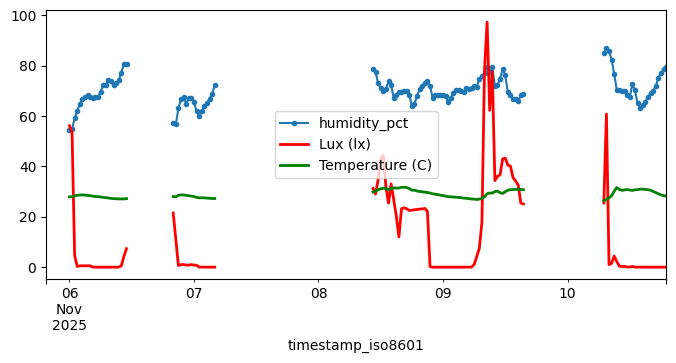

In [272]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df.iloc[-240:]["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))


# Add another column, e.g., temperature, as a line in a different color
df.iloc[-240:]["lux_lx"].plot(
    ax=ax, color='red', linewidth=2, label="Lux (lx)"
)

df.iloc[-240:]["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [273]:
# The gaps indicate times the board was off

In [274]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3211 entries, 2025-09-04 22:00:00+00:00 to 2025-11-10 19:00:00+00:00
Freq: 30min
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   3211 non-null   float64
 1   is_raining     3211 non-null   float64
 2   lux_lx         3211 non-null   float64
 3   pressure_pa    3211 non-null   float64
 4   temperature_c  3211 non-null   float64
dtypes: float64(5)
memory usage: 279.6 KB


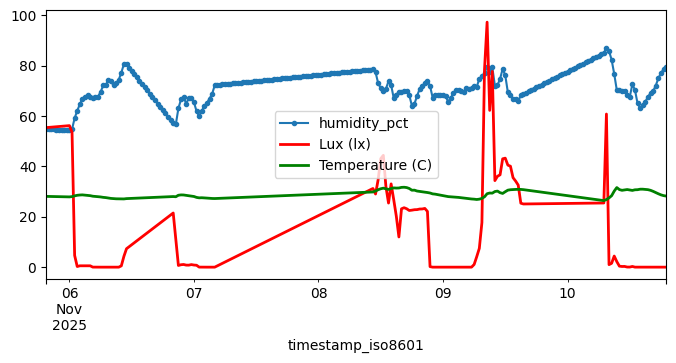

In [275]:
# The last 5-day period
ax = df.iloc[-240:]["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))


# Add another column, e.g., temperature, as a line in a different color
df.iloc[-240:]["lux_lx"].plot(
    ax=ax, color='red', linewidth=2, label="Lux (lx)"
)

df.iloc[-240:]["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

## Normalizing

In [276]:
df.describe()

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
count,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000
mean,84.561803,0.005116,3664.168166,101076.589168,29.014012
std,12.887869,0.062443,5893.033295,157.332053,3.475414
min,54.362780,0.000000,0.000000,100635.793644,22.989888
25%,74.751893,0.000000,0.000000,100963.057363,25.996689
50%,86.173429,0.000000,515.948858,101080.051792,28.818711
75%,96.672447,0.000000,5009.655660,101187.495746,30.531140
max,100.000000,1.000000,28891.834070,101492.141722,43.539995


In [277]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[df.select_dtypes(include='number').columns] = scaler.fit_transform(
    df.select_dtypes(include='number')
)

In [278]:
df.describe()

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
count,3.211000e+03,3.211000e+03,3211.000000,3.211000e+03,3.211000e+03
mean,-1.053312e-15,1.770272e-17,0.000000,5.747187e-14,9.603723e-16
std,1.000156e+00,1.000156e+00,1.000156,1.000156e+00,1.000156e+00
min,-2.343578e+00,-8.194837e-02,-0.621876,-2.802126e+00,-1.733624e+00
25%,-7.612925e-01,-8.194837e-02,-0.621876,-7.217187e-01,-8.683258e-01
50%,1.250693e-01,-8.194837e-02,-0.534311,2.201181e-02,-5.620358e-02
75%,9.398396e-01,-8.194837e-02,0.228354,7.050302e-01,4.365995e-01
max,1.198072e+00,1.593522e+01,4.281597,2.641657e+00,4.180292e+00


## Train, Test Split

In [279]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 2568
Valid: 321
Test: 322


In [280]:
import tensorflow as tf

seq_length = 12 # since each instance is a 30-min period, and we want a 6hr window
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=df_train["temperature_c"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=df_valid["temperature_c"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [281]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [282]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [283]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

In [284]:
history = model.fit(
    train_dataset, validation_data=valid_dataset,
    epochs=500 , callbacks=[early_stopping_cb]
)

Epoch 1/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4675 - mae: 0.8397 - val_loss: 0.4252 - val_mae: 0.7940
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4003 - mae: 0.7609 - val_loss: 0.4216 - val_mae: 0.7928
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4018 - mae: 0.7658 - val_loss: 0.4269 - val_mae: 0.7989
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4002 - mae: 0.7638 - val_loss: 0.4321 - val_mae: 0.8031
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4002 - mae: 0.7608 - val_loss: 0.4307 - val_mae: 0.8006
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3900 - mae: 0.7498 - val_loss: 0.4293 - val_mae: 0.7970
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3832 - mae: 0.7398 - val_loss: 0.4357 - val_mae: 0.8050
Epoch 8/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3891 - mae: 0.7478 - val_loss: 0.4350 - val_mae: 0.8015
Epoch 9/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.38

In [285]:
df.head()

,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,,
2025-09-04 22:00:00+00:00,-1.646756,-0.081948,-0.617363,-0.654586,-0.242175
2025-09-04 22:30:00+00:00,-1.134133,-0.081948,-0.614718,-0.680258,-0.191862
2025-09-04 23:00:00+00:00,-0.711112,-0.081948,-0.605343,-0.655005,0.450644
2025-09-04 23:30:00+00:00,-0.595567,-0.081948,-0.605279,-0.432934,0.375652
2025-09-05 00:00:00+00:00,-0.409131,-0.081948,-0.605274,-0.320053,0.207375


In [286]:
model.evaluate(valid_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4367 - mae: 0.8201


[0.421610027551651, 0.7927822470664978]